# Tutorial: BAX to improve Accuracy of Interpretability Measures 

In [2]:
# Needed functionality from botorch 
from botorch.test_functions.synthetic import ApproximateObjective, StyblinskiTang
from botorch.acquisition.algorithm import PDPAlgorithm
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.acquisition.bax import InfoBAX
from botorch import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement, PosteriorVariance
from botorch.test_functions.synthetic import Levy
from botorch.acquisition.predictive_entropy_search import qMultiObjectivePredictiveEntropySearch
from botorch.optim.optimize import optimize_acqf

import torch
import gpytorch

In [3]:
# Other helper libraries
from argparse import Namespace

import numpy as np 
import matplotlib.pyplot as plt 
import copy
import pprint 
import time

import logging
logger = logging.getLogger()
# logger.setLevel(logging.INFO)
logger.setLevel(logging.CRITICAL)

torch.set_default_dtype(torch.float)

In [82]:
# Helper functions 

def plot_test_function(f, resolution=100): 
    x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], resolution)
    x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], resolution)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)
    Y = f(X).reshape(resolution, resolution).numpy()

    plt.figure(figsize=(5, 4))
    plt.contourf(X1.numpy(), X2.numpy(), Y, levels=8)
    plt.colorbar()
    plt.title(str(f))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

def plot_pdp(outlist, title, labels=["PD function"], colors=["blue"]): 
    """
    out: result of alg.run_algorithm_on_f(f), stored in a list
    """

    for out, label, color in zip(outlist, labels, colors): 

        x = out[1].x
        y = out[1].y.detach()

        # Plot the main curve
        plt.plot(x, y, label=label, color=color)

    # Optional configurations
    plt.title(title)
    plt.xlabel(r'$x_S$')
    plt.ylabel(r'$f_S(x_S)$')
    plt.legend()
    plt.grid(True)

def run_optimization_loop(acq_function, initial_design, f, num_iterations, algorithm):

    tstart = time.time()

    if acq_function == "BAX" or acq_function == "BOBAX": 
        algorithm.initialize()

    data = copy.deepcopy(initial_design)
    best_f = data.y.min()

    d = f.dim

    f_bounds = f.bounds.clone().detach()

    exe_path = algorithm.params.x_path.unsqueeze(0)

    model_list = []

    for iteration in range(num_iterations):

        model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
        mll = gpytorch.ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll);       

        if acq_function == "BAX": 
            acq = InfoBAX(model=model, algorithm=algorithm, exe_path_deterministic_x=True, n_path=1)            
        if acq_function == "EI": 
            acq = ExpectedImprovement(model=model, best_f=best_f, maximize=False)  
        if acq_function == "PV": 
            acq = PosteriorVariance(model=model, maximize=False)  
        if acq_function == "BOBAX": 
            EIG = InfoBAX(model=model, algorithm=algorithm, exe_path_deterministic_x=True, n_path=1)
            # Tensor of shape (n_path, len_exe_path, d)
            # Corresponding to (n_batch, P, d)
            pareto_sets = torch.stack([torch.stack(el.x) for el in EIG.exe_path_list], dim=0)

            acq = qMultiObjectivePredictiveEntropySearch(
                        model=model,
                        pareto_sets=pareto_sets,
                        maximize=False
                    )

        candidate, _ = optimize_acqf(acq, f_bounds, 1, 1, 512, sequential=True)

        data.x = torch.cat((data.x, candidate), dim=0)   
        data.y = torch.cat((data.y, f(candidate).unsqueeze(0)), dim=0)

        best_f = data.y.min()

        # model_list.append(copy.deepcopy(model))

    tend = time.time()

    return model, data, tend - tstart

def compute_approximated_PD(f, approx_model, alg):
    f_approx_bounds = f.bounds.clone().detach()
    f_approx = ApproximateObjective(dim=f.dim, bounds=f_approx_bounds.T, model=approx_model)

    alg.initialize()

    out_approx = alg.run_algorithm_on_f(f_approx)

    return(out_approx)

## Test function 

We have a look at the d-dimensional Styblinski-Tang function 

$$ \frac{1}{2} \sum_{i = 1}^d (x_i^4 - 16 x_i^2 + 5 x_i), x_i \in [-5, 5]. $$

Here $d = 2$ for visualization purposes. 

In [57]:
d = 2
f = StyblinskiTang(dim=d)

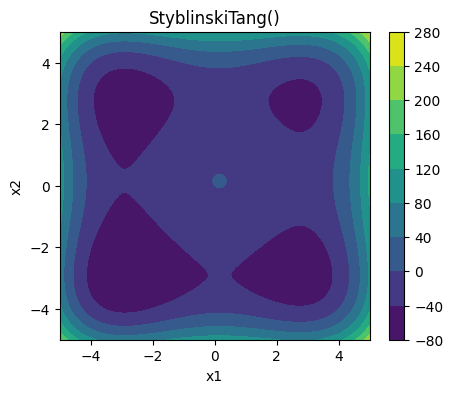

In [58]:
# PLOT
plot_test_function(f)

We are interested in visualizing the partial dependence of the *true* function $f$, which is 

$$
    f_1\left(x_1\right) = \int_{X_2} f(x_1, x_2) ~\mathrm{d}\mathbb{P}(x_2)
$$



**Note**: Practically, we would deal with functions of dimensions higher than $2$, which are challenging to visualize directly. Computing the partial dependence allows us to gain insights into multidimensional functions, making them more interpretable in a visual format.

In [59]:
params = {"name": "PDP", "xs": 0, "n_points": 20, "bounds": f.bounds, "grid_size": 20}
alg = PDPAlgorithm(params)
alg.initialize()
out = alg.run_algorithm_on_f(f)

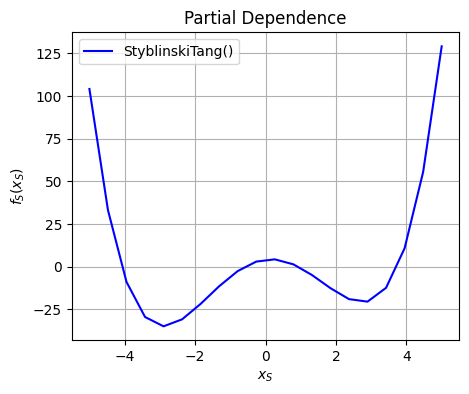

In [60]:
# PLOT 
plt.figure(figsize=(5, 4))

plot_pdp([out], title="Partial Dependence", labels=[str(f)])

## Black-box test functions

In real-world settings, we often deal with functions without knowing their analytical formula. In addition, evaluating them for a given $x$ is often expensive. 

We may only have access to a set of sample points of *limited* size, which we refer to as archive $A_T = \{(x^{(i)}, y^{(i)})\}_{i = 1, ..., T}$, where each $x^{(i)}$ is associated with a function value $y^{(i)} = f(x^{(i)})$.

We can fit a Gaussian process (GP) model $\hat f$ as approximation to the true but unknown $f$. $\hat f$ allows us to make predictions and further analyses. 

We assume we have have access to an archive $A_T$ of size $T = 8$, with $x^{(i)}$ sampled from a Sobol sequence, and have fitted a GP model thereon. 

In [61]:
sobol = torch.quasirandom.SobolEngine(dimension=d, scramble=True, seed=1234)

data = Namespace()
X = sobol.draw(n=4*f.dim)
data.x = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
data.y = f(data.x).unsqueeze(0).T

model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
mll = gpytorch.ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

In [62]:
gp_params = {"Lengthscale": model.covar_module.base_kernel.lengthscale[0].tolist(), 
             "Outputscale": model.covar_module.outputscale.tolist(), 
             "Noise": model.likelihood.noise.tolist()}

pprint.pprint(gp_params)

{'Lengthscale': [0.341065629487422, 0.4608653663673896],
 'Noise': [0.031678025019246776],
 'Outputscale': 1.3291779190374358}


Instead of visualizing the PD of $f$, we visualize the PD of $\hat f$. 

In [63]:
f_approx_bounds = f.bounds.clone().detach()
f_approx = ApproximateObjective(dim=d, bounds=f_approx_bounds, model=model)

alg_approx = PDPAlgorithm(params)
alg_approx.initialize()

out_approx = alg_approx.run_algorithm_on_f(f_approx)

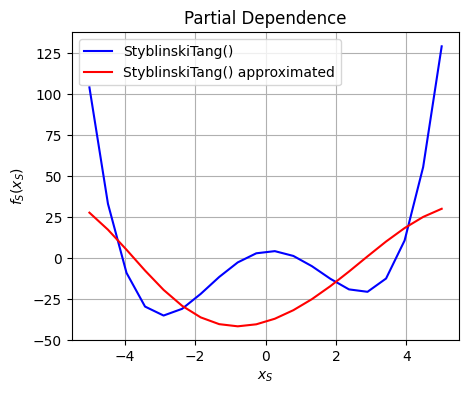

In [64]:
# PLOT 
plt.figure(figsize=(5, 4))

plot_pdp([out, out_approx], title="Partial Dependence", labels=[str(f), str(f) + " approximated"], colors=["blue", "red"])

This is only an approximation of certain quality, with the quality depending on the quality of the model $\hat f$, which in turn depends on the sample $A_T$ is was trained on. 


**Key question**: How to optimally design $A_T$ with such that we can approximate the PD function best? 

## Expected information gain

We would like to compute the expected information gain (EIG) of a point $\bm{\tilde x}$ on the algorithm output $\mathcal{O}_\mathcal{A}$ (i.e., the PDP). 

The formula for this is: 

$$
    \textrm{EIG}^e_T(\mathbf{x}) = \underbrace{\mathbb{H}\left[f_{\mathbf{x}}|A_T\right]}_{(1)} - \underbrace{\mathbb{E}_{e_{\mathcal{A}}|A_T}\left[\mathbb{H}\left[f_{\mathbf{x}}|A_T, e_\mathcal{A}\right]\right]}_{(1)}
$$


Here, $e_\mathcal{A}$ is the execution path, i.e., the sequence of all evaluations the PDP algorithm $\mathcal{A}$ traverses, which gives full information about the output $\mathcal{O}_\mathcal{A}$ of the PDP algorithm. 



Let's say we want to compute the information gain of a randomly drawn points $\bm{\tilde x}$. 


In [65]:
EIG = InfoBAX(model=model, algorithm=alg, exe_path_deterministic_x=True, n_path=1)

In [66]:
candidate_set = torch.rand(200, d, device="cpu", dtype=torch.float)
candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set

In [69]:
x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], 100)
x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], 100)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1).to(dtype=torch.float64)

acq_values = EIG.forward(X).detach().numpy()

In [70]:
model.eval()
with torch.no_grad():
    post = model.posterior(X)
    mean = post.mean.cpu().numpy()
    variance = post.variance.cpu().numpy()
    std_dev = torch.sqrt(post.variance).cpu().numpy()
    

In [71]:
from scipy.stats import norm

gamma = (mean - data.y.min().cpu().numpy()) / std_dev

ei = [sd * (g * norm.cdf(g) + norm.pdf(g)) for g, sd in zip(gamma, std_dev)]
ei = np.array(ei)

In [72]:
grid = torch.stack([torch.stack(el.x) for el in EIG.exe_path_list], dim=0).squeeze(0).cpu().numpy()

In [73]:
Xtrain = data.x

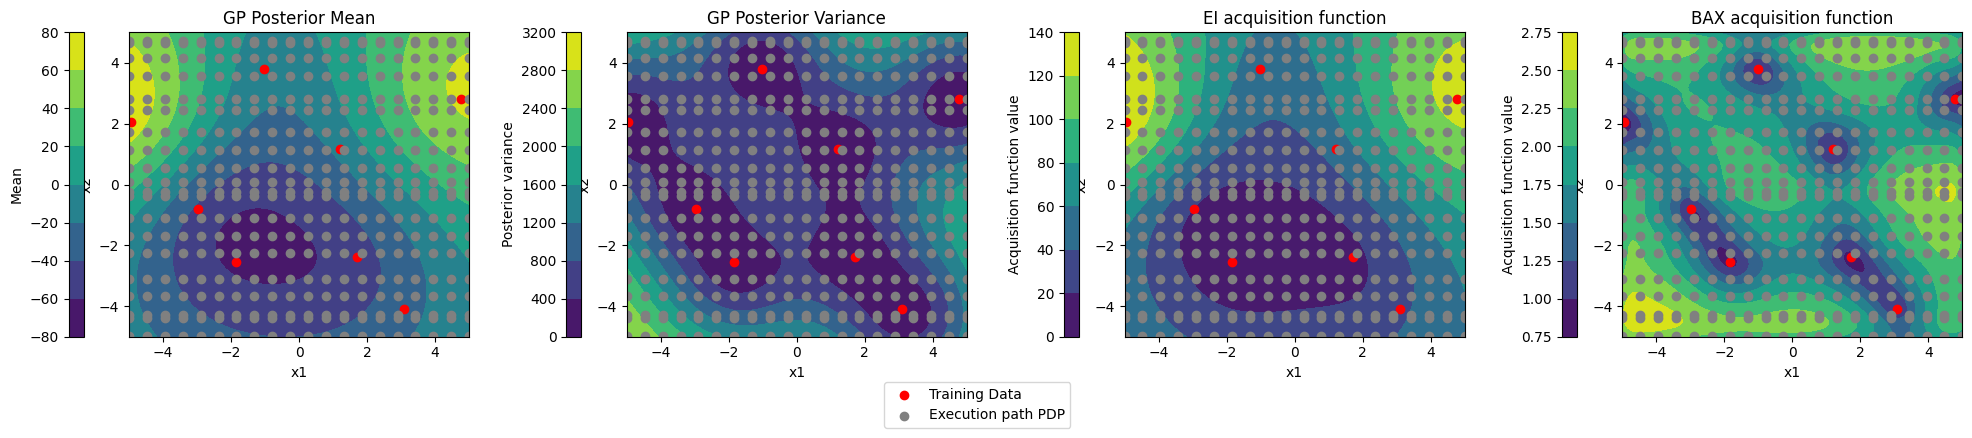

In [74]:
# PLOT 
fig, axarr = plt.subplots(1, 4, figsize=(20, 4))

# Subplot (1, 1): Posterior mean
contour_mean = axarr[0].contourf(X1.numpy(), X2.numpy(), mean.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[0], location='left')
cbar_mean.ax.set_ylabel('Mean')
scatter_points = axarr[0].scatter(Xtrain[:, 0], Xtrain[:, 1], c="red", label='Training Data')
scatter_points = axarr[0].scatter(grid[:, 0], grid[:, 1], c="grey", label='Execution path PDP')
axarr[0].set_title("GP Posterior Mean")
axarr[0].set_xlabel("x1")
axarr[0].set_ylabel("x2")

# # Subplot (1, 2): Posterior variance
contour_mean = axarr[1].contourf(X1.numpy(), X2.numpy(), variance.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[1], location='left')
cbar_mean.ax.set_ylabel('Posterior variance')
scatter_points = axarr[1].scatter(Xtrain[:, 0], Xtrain[:, 1], c="red", label='Training Data')
scatter_points = axarr[1].scatter(grid[:, 0], grid[:, 1], c="grey", label='Execution path PDP')
axarr[1].set_title("GP Posterior Variance")
axarr[1].set_xlabel("x1")
axarr[1].set_ylabel("x2")

# # Subplot (1, 3): EI criterion
contour_mean = axarr[2].contourf(X1.numpy(), X2.numpy(), ei.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[2], location='left')
cbar_mean.ax.set_ylabel('Acquisition function value')
scatter_points = axarr[2].scatter(Xtrain[:, 0], Xtrain[:, 1], c="red", label='Training Data')
scatter_points = axarr[2].scatter(grid[:, 0], grid[:, 1], c="grey", label='Execution path PDP')
axarr[2].set_title("EI acquisition function")
axarr[2].set_xlabel("x1")
axarr[2].set_ylabel("x2")

# # Subplot (1, 4): EIG criterion
contour_mean = axarr[3].contourf(X1.numpy(), X2.numpy(), acq_values.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[3], location='left')
cbar_mean.ax.set_ylabel('Acquisition function value')
scatter_points = axarr[3].scatter(Xtrain[:, 0], Xtrain[:, 1], c="red", label='Training Data')
scatter_points = axarr[3].scatter(grid[:, 0], grid[:, 1], c="grey", label='Execution path PDP')
axarr[3].set_title("BAX acquisition function")
axarr[3].set_xlabel("x1")
axarr[3].set_ylabel("x2")

handles, labels = axarr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),)

plt.tight_layout()
plt.show()

## Run optimization 


In [87]:
res_BAX = run_optimization_loop("BAX", data, f, 20, PDPAlgorithm(params))

In [88]:
res_EI = run_optimization_loop("EI", data, f, 20, PDPAlgorithm(params))

In [89]:
res_PV = run_optimization_loop("PV", data, f, 20, PDPAlgorithm(params))

In [90]:
pprint.pprint({"Runtime BAX": res_BAX[2], "Runtime EI": res_EI[2], "Runtime PV": res_PV[2]})

{'Runtime BAX': 34.44077277183533,
 'Runtime EI': 17.56643772125244,
 'Runtime PV': 8.433818817138672}


In [91]:
out_BAX = compute_approximated_PD(f, res_BAX[0], alg)
out_EI = compute_approximated_PD(f, res_EI[0], alg)
out_PV = compute_approximated_PD(f, res_PV[0], alg)

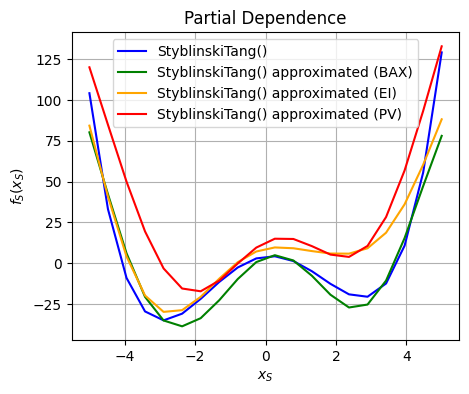

In [92]:
# PLOT 
plt.figure(figsize=(5, 4))

outputs = [out, out_BAX, out_EI, out_PV]
labels = [str(f), str(f) + " approximated (BAX)", str(f) + " approximated (EI)", str(f) + " approximated (PV)"]
colors = ["blue", "green", "orange", "red"]

plot_pdp(outputs, title="Partial Dependence", labels=labels, colors=colors)

## Initial benchmark  

In [39]:
d = 2
f = StyblinskiTang(dim=d)

n_repl = 20
n_iters = 10 * d
n_init = 2 * d

times = {"BAX": [], "EI": [], "PV": []}
mean_abs_error = {"BAX": [], "EI": [], "PV": []}
outputs = {}

params = {"name": "PDP", "xs": 0, "n_points": 15 * d, "bounds": f.bounds, "grid_size": 10}
alg = PDPAlgorithm(params)
alg.initialize()
out = alg.run_algorithm_on_f(f)

methods = ["BAX", "EI", "PV"]

for repl in range(n_repl):

    print(repl)
    
    outputs[f'repl_{repl+1}'] = {}

    sobol = torch.quasirandom.SobolEngine(dimension=d, scramble=True, seed=repl)

    data = Namespace()
    X = sobol.draw(n=n_init)
    data.x = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
    data.y = f(data.x).unsqueeze(0).T

    for method in methods: 

        res = run_optimization_loop(method, data, f, n_iters, PDPAlgorithm(params))
        out_approx = compute_approximated_PD(f, res[0], PDPAlgorithm(params))
        
        times[method].append(round(res[2], 4))
        mean_abs_error[method].append(torch.mean(torch.abs(out[1].y - out_approx[1].y)))
        outputs[f'repl_{repl+1}'][method] = out_approx[1].y


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [46]:
for method in methods: 
    mean_abs_error[method] = torch.stack(mean_abs_error[method]).detach() 

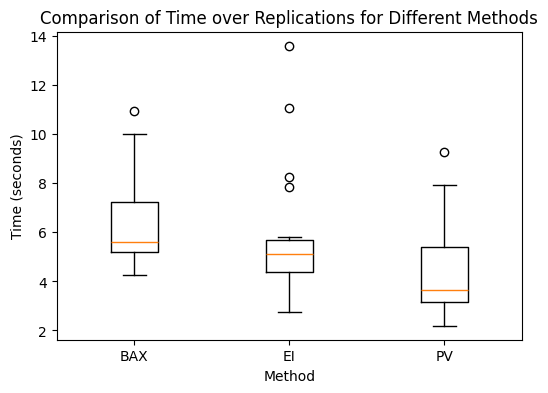

In [47]:
# Prepare data for boxplot
data_to_plot = [times[method] for method in methods]
labels = methods

# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot, labels=methods)
plt.title('Comparison of Time over Replications for Different Methods')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')
plt.show()

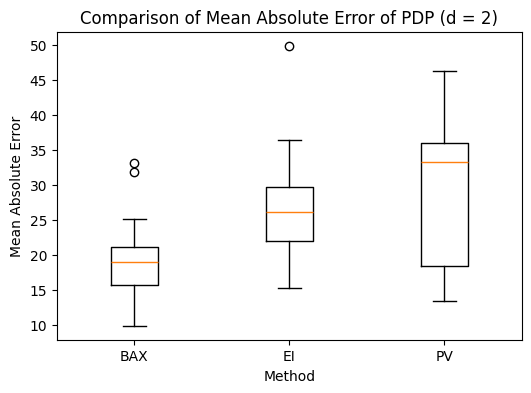

In [49]:
# Prepare data for boxplot
data_to_plot = [mean_abs_error[method] for method in methods]
labels = methods

# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot, labels=methods)
plt.title('Comparison of Mean Absolute Error of PDP (d = 2)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Method')
plt.show()

In [26]:
d = 5
f = StyblinskiTang(dim=d)

n_repl = 20
n_iters = 10 * d
n_init = 2 * d

times = {"BAX": [], "EI": [], "PV": []}
mean_abs_error = {"BAX": [], "EI": [], "PV": []}
outputs = {}

params = {"name": "PDP", "xs": 0, "n_points": 10 * d, "bounds": f.bounds, "grid_size": 20}
alg = PDPAlgorithm(params)
alg.initialize()
out = alg.run_algorithm_on_f(f)

methods = ["BAX", "EI", "PV"]

for repl in range(n_repl):

    print(repl)
    
    outputs[f'repl_{repl+1}'] = {}

    sobol = torch.quasirandom.SobolEngine(dimension=d, scramble=True, seed=repl)

    data = Namespace()
    X = sobol.draw(n=n_init)
    data.x = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
    data.y = f(data.x).unsqueeze(0).T

    model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
    mll = gpytorch.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);

    for method in methods: 

        res = run_optimization_loop(method, data, f, n_iters, PDPAlgorithm(params))
        out_approx = compute_approximated_PD(f, res[0], PDPAlgorithm(params))
        
        times[method].append(round(res[2], 4))
        mean_abs_error[method].append(torch.mean(torch.abs(out[1].y - out_approx[1].y)))
        outputs[f'repl_{repl+1}'][method] = out_approx[1].y

for method in methods: 
    mean_abs_error[method] = torch.stack(mean_abs_error[method]).detach() 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


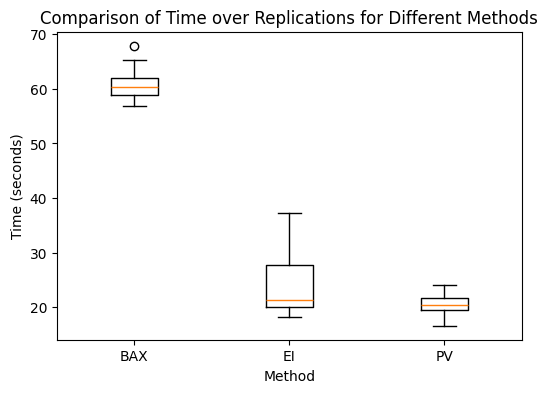

In [28]:
# Prepare data for boxplot
data_to_plot = [times[method] for method in methods]
labels = methods

# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot, labels=methods)
plt.title('Comparison of Time over Replications for Different Methods')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')
plt.show()

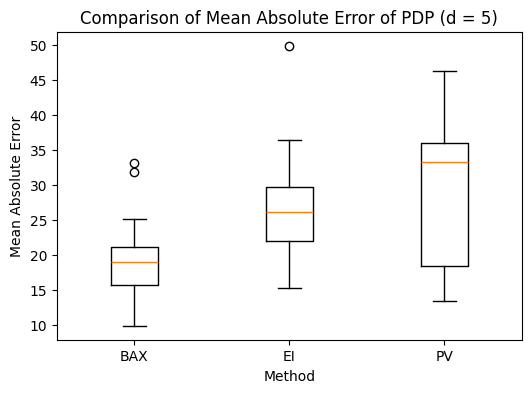

In [50]:
# Prepare data for boxplot
data_to_plot = [mean_abs_error[method] for method in methods]
labels = methods

# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot, labels=methods)
plt.title('Comparison of Mean Absolute Error of PDP (d = 5)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Method')
plt.show()

In [35]:
d = 3
f = Levy(dim=d)

n_repl = 20
n_iters = 10 * d
n_init = 2 * d

times = {"BAX": [], "EI": [], "PV": []}
mean_abs_error = {"BAX": [], "EI": [], "PV": []}
outputs = {}

params = {"name": "PDP", "xs": 0, "n_points": 10 * d, "bounds": f.bounds, "grid_size": 20}
alg = PDPAlgorithm(params)
alg.initialize()
out = alg.run_algorithm_on_f(f)

methods = ["BAX", "EI", "PV"]

for repl in range(n_repl):

    print(repl)
    
    outputs[f'repl_{repl+1}'] = {}

    sobol = torch.quasirandom.SobolEngine(dimension=d, scramble=True, seed=repl)

    data = Namespace()
    X = sobol.draw(n=n_init)
    data.x = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
    data.y = f(data.x).unsqueeze(0).T

    model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
    mll = gpytorch.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);

    for method in methods: 

        res = run_optimization_loop(method, data, f, n_iters, PDPAlgorithm(params))
        out_approx = compute_approximated_PD(f, res[0], PDPAlgorithm(params))
        
        times[method].append(round(res[2], 4))
        mean_abs_error[method].append(torch.mean(torch.abs(out[1].y - out_approx[1].y)))
        outputs[f'repl_{repl+1}'][method] = out_approx[1].y

for method in methods: 
    mean_abs_error[method] = torch.stack(mean_abs_error[method]).detach() 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


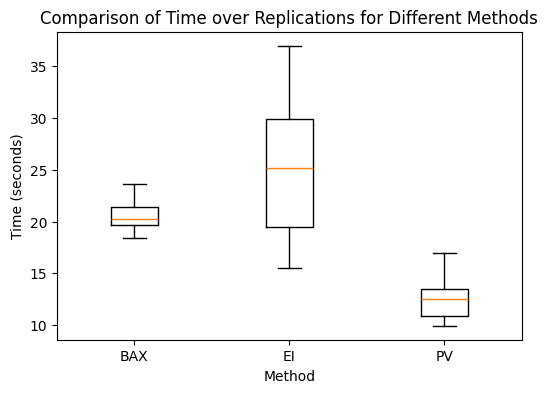

In [36]:
# Prepare data for boxplot
data_to_plot = [times[method] for method in methods]
labels = methods

# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot, labels=methods)
plt.title('Comparison of Time over Replications for Different Methods')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')
plt.show()

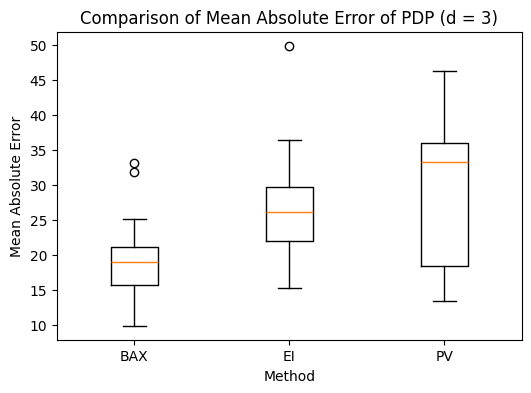

In [51]:
# Prepare data for boxplot
data_to_plot = [mean_abs_error[method] for method in methods]
labels = methods

# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot, labels=methods)
plt.title('Comparison of Mean Absolute Error of PDP (d = 3)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Method')
plt.show()

#### Computation of the acquisition function

Now that we got the acquisition function together, we can compute it's value for a candidate $\mathbf{\tilde x}$. 

In [226]:
from botorch.optim.optimize import optimize_acqf



In [227]:
candidates

tensor([[-4.6761, -2.7269]], dtype=torch.float64)

In [22]:
# EIG.forward(X)

from botorch.acquisition.multi_objective.predictive_entropy_search import qMultiObjectivePredictiveEntropySearch

acq = qMultiObjectivePredictiveEntropySearch(
            model=model,
            pareto_sets=pareto_sets,
            maximize=False
        )

Now let's compute it for a bunch of candidate points and let's see what is the best one to pick! 

In [23]:
candidate_set = torch.rand(200, d, device="cpu")
candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set
candidate_set = candidate_set.unsqueeze(1)


In [24]:
acq_values = acq(candidate_set)

: 

In [ ]:
acq_values

In [ ]:
acq_values = EIG.forward(candidate_set)
acq_values 

In [ ]:
# PLOT
x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], 100)
x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], 100)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

model.eval()
with torch.no_grad():
    post = model.posterior(X)
    mean = post.mean.cpu().numpy()
    variance = post.variance.cpu().numpy()
    std_dev = torch.sqrt(post.variance).cpu().numpy()

In [ ]:
pareto_sets

In [ ]:
# PLOT 

fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

# Plot mean on the left subplot
contour_mean = axarr[0].contourf(X1.numpy(), X2.numpy(), mean.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[0], location='left')
cbar_mean.ax.set_ylabel('Mean')
axarr[0].set_title("GP Posterior Mean")
axarr[0].set_xlabel("x1")
axarr[0].set_ylabel("x2")

candidate_set_np = candidate_set.detach().numpy()
acq_values_np = acq_values.detach().numpy()
grid = pareto_sets.detach().numpy()

# Overlay training data on the mean plot
scatter_points = axarr[0].scatter(candidate_set_np[:, 0, 0], candidate_set_np[:, 0, 1], c=acq_values_np, cmap='jet', s=50, zorder=10, label='Training Data')
scatter_points = axarr[0].scatter(grid[0, :, 0], grid[0, :, 1], color="white", s=50, zorder=10, label='Training Data')
cbar_points_mean = fig.colorbar(scatter_points, ax=axarr[0], location='right')
cbar_points_mean.ax.set_ylabel('Acquisition Values')

# Plot standard deviation on the right subplot
contour_std = axarr[1].contourf(X1.numpy(), X2.numpy(), std_dev.reshape(100, 100))
cbar_std = fig.colorbar(contour_std, ax=axarr[1], location='left')
cbar_std.ax.set_ylabel('Standard Deviation')
axarr[1].set_title("GP Posterior Standard Deviation")
axarr[1].set_xlabel("x1")
axarr[1].set_ylabel("x2")

# Overlay training data on the standard deviation plot
scatter_points_std = axarr[1].scatter(candidate_set_np[:, 0, 0], candidate_set_np[:, 0, 1], c=acq_values_np, cmap='jet', s=50, zorder=10, label='Training Data')
scatter_points = axarr[1].scatter(grid[0, :, 0], grid[0, :, 1], color="white", s=50, zorder=10, label='Training Data')
cbar_points_std = fig.colorbar(scatter_points_std, ax=axarr[1], location='right')
cbar_points_std.ax.set_ylabel('Acquisition Values')

plt.tight_layout()
plt.show()


In [ ]:
acq_values

## Running BAX for PDP 


In [107]:
d = 2
f = StyblinskiTang(dim=d)

# Initial design 
sobol = torch.quasirandom.SobolEngine(dimension=d, scramble=True, seed=123)
X = sobol.draw(n=2*f.dim)
X = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
Y = f(X).unsqueeze(0).T

data = Namespace(x = X, y = Y)

num_iterations = 10

params = {"name": "PDP", "xs": 1, "n_points": 20, "bounds": f.bounds, "grid_size": 20}
alg = PDPAlgorithm(params)
alg.initialize()

# Optimization loop 
for iteration in range(num_iterations):
    model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
    mll = gpytorch.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);

    pareto_sets = torch.stack([torch.stack(el.x) for el in EIG.exe_path_list], dim=0)

    qMultiObjectivePredictiveEntropySearch(
                model=model,
                pareto_sets=pareto_sets,
                maximize=False
            )

    candidate_set = torch.rand(50, d, device="cpu")
    candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set
    candidate_set = candidate_set

    acq_values = EIG.forward(candidate_set)

    idx_best = np.argmax(acq_values)  
    candidate_new = candidate_set[idx_best, ].unsqueeze(0)

    data.x = torch.cat((data.x, candidate_set[idx_best, ].unsqueeze(0)), dim=0)   
    data.y = torch.cat((data.y, f(candidate_new).unsqueeze(0)), dim=0)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
f_approx_bounds = f.bounds.clone().detach()
f_approx_new = ApproxmiateObjective(dim=d, bounds=f_approx_bounds, model=model)

In [ ]:
params = {"name": "PDP", "xs": 1, "n_points": 50, "bounds": f.bounds, "grid_size": 20}

alg_approx_new = PDPAlgorithm(params)
alg_approx_new.initialize()

out_approx_new = alg_approx_new.run_algorithm_on_f(f_approx_new)

In [ ]:
# PLOT 

plt.figure(figsize=(5, 4))

x_approx_new = out_approx_new[1].x.tolist()
y_approx_new = out_approx_new[1].y.tolist()

# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')
plt.plot(x_approx, y_approx, label='PD function (approximated)', color='red')
plt.plot(x_approx_new, y_approx_new, label='PD function (approximated, after BAX)', color='green')

# Optional configurations
plt.title(r'Approximated PD function for Styblinski-Tang function')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$f_1(x_1)$')
plt.legend()
plt.grid(True)

In [ ]:
# Initial design 
from botorch.acquisition.analytic import ExpectedImprovement


sobol = torch.quasirandom.SobolEngine(dimension=d, scramble=True, seed=123)
X = sobol.draw(n=20)
X = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
Y = f(X).unsqueeze(0).T

best_f = Y.min()

data = Namespace(x = X, y = Y)

num_iterations = 10

# Optimization loop 
for iteration in range(num_iterations):
    model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
    mll = gpytorch.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);

    params = {"name": "BAX", "n_path": 10, "exe_path_dependencies": False}
    ei = ExpectedImprovement(model=model, best_f=best_f, maximize=True)
    
    candidate_set = torch.rand(50, d, device="cpu")
    candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set
    candidate_set = candidate_set.unsqueeze(1)

    acq_values = ei.forward(candidate_set)

    idx_best = np.argmax(acq_values.detach().numpy())  
    candidate_new = candidate_set[idx_best, ].unsqueeze(0)

    data.x = torch.cat((data.x, candidate_set[idx_best, ]), dim=0)   
    data.y = torch.cat((data.y, f(candidate_new)), dim=0)

    best_f = data.y.min()

In [ ]:
f_approx_bounds = f.bounds.clone().detach()
f_approx_new = ApproxmiateObjective(dim=d, bounds=f_approx_bounds, model=model)

In [ ]:
params = {"name": "PDP", "xs": 1, "n_points": 50, "bounds": f.bounds, "grid_size": 20}

alg_approx_new = PDPAlgorithm(params)
alg_approx_new.initialize()

out_approx_new_ei = alg_approx_new.run_algorithm_on_f(f_approx_new)

In [ ]:
# PLOT 

plt.figure(figsize=(5, 4))

x_approx_new = out_approx_new[1].x.tolist()
y_approx_new = out_approx_new[1].y.tolist()

x_approx_new_ei = out_approx_new_ei[1].x.tolist()
y_approx_new_ei = out_approx_new_ei[1].y.tolist()


# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')
plt.plot(x_approx, y_approx, label='PD function (approximated)', color='red')
plt.plot(x_approx_new, y_approx_new, label='PD function (approximated, after BAX)', color='green')
plt.plot(x_approx_new_ei, y_approx_new_ei, label='PD function (approximated, after EI)', color='orange')

# Optional configurations
plt.title(r'Approximated PD function for Styblinski-Tang function')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$f_1(x_1)$')
plt.legend()
plt.grid(True)